# Example Notebook for Keysight Network Analyzers

This notebook is indendet to give an overview over the functions implemented in the QCoDeS driver for the Keysight network analyzers. The driver is implemented to be generic as possible, with individual instrument drivers filling in only the hardware limits of the instrument, so although this example uses the N5245A or N5222B, the concepts and code should work for any keysight network analyzer.

In [1]:
%matplotlib inline

In [2]:
# Import Dependencies

import logging
import matplotlib.pyplot as plt

# qcodes imports
import qcodes as qc
from qcodes.dataset.experiment_container import new_experiment, load_experiment_by_name
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.instrument_drivers.Keysight.N5245A import N5245A 
from qcodes.instrument_drivers.Keysight.N5222B import N5222B

#setup
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Start experiment
exp_name = 'PNA_Example'
sample_name = 'Thru_Coax'
try:
    exp = load_experiment_by_name(exp_name, sample=sample_name)
    print('Experiment loaded. Last ID no:', exp.last_counter)
except ValueError:
    exp = new_experiment(exp_name, sample_name)
    print('Starting new experiment.')

Experiment loaded. Last ID no: 65


## Connect to the instrument

You will have to insert the correct VISA address for your PNA below. Two examples are given below. Uncomment the appropriate line 

In [3]:
pna = N5222B("pna", "TCPIP0::B4801-CTW-PNA1.local::inst0::INSTR")

Connected to: Keysight Technologies N5222B (serial:MY57041028, firmware:A.13.25.04) in 0.16s


## Windows 

Lets get a list of all windows on the instrument 

In [17]:
pna.windows

ChannelList(<N5222B: pna>, N52xxWindow, [])

Add a window. Check the instrument display; you should see a new window without traces 

In [18]:
pna.windows.add()

<N52xxWindow: pna_window2 of N5222B: pna>

In [19]:
pna.windows

ChannelList(<N5222B: pna>, N52xxWindow, [<N52xxWindow: pna_window2 of N5222B: pna>])

Delete the newest windows 

In [20]:
window = pna.windows[-1]
window.delete()
pna.windows

ChannelList(<N5222B: pna>, N52xxWindow, [])

In [21]:
try: 
    window.ask("")
except RuntimeError as err: 
    print("Deleted channel object cannot communicate with the instrument!")
    print(err)

Deleted channel object cannot communicate with the instrument!
Object does not exist (anymore) on the instrument


## Channels 

The same mechanism as above works for traces and channels 

In [13]:
# list channels 
pna.channels

ChannelList(<N5222B: pna>, N52xxChannel, [])

In [14]:
pna.channels.add()

<N52xxChannel: pna_CHN1 of N5222B: pna>

In [15]:
pna.channels

ChannelList(<N5222B: pna>, N52xxChannel, [<N52xxChannel: pna_CHN1 of N5222B: pna>])

## Traces 

Traces are listed in channels 

In [7]:
pna.channels[0].traces

ChannelList(<N52xxChannel: pna_CHN1 of N5222B: pna>, N52xxTrace, [<N52xxTrace: pna_CHN1_CHN1_S11_1 of N52xxChannel: pna_CHN1>])

In [8]:
pna.channels[0].traces.add(trace_type="S11")

<N52xxTrace: pna_CHN1_CHN1_S11_2 of N52xxChannel: pna_CHN1>

In [9]:
pna.channels[0].traces

ChannelList(<N52xxChannel: pna_CHN1 of N5222B: pna>, N52xxTrace, [<N52xxTrace: pna_CHN1_CHN1_S11_1 of N52xxChannel: pna_CHN1>, <N52xxTrace: pna_CHN1_CHN1_S11_2 of N52xxChannel: pna_CHN1>])

In [10]:
pna.channels[0].traces[0].short_name

'CHN1_S11_1'

In [22]:
pna.channels[0].traces["CHN1_S11_1"]

<N52xxTrace: pna_CHN1_CHN1_S11_1 of N52xxChannel: pna_CHN1>

## Starting from scratch 

In [11]:
def reset_instrument(): 
    # Start over: delete all traces, channels and windows 

    pna.reset_instrument()
    
    for window in pna.windows: 
        window.delete()

    for channel in pna.channels: 
        channel.delete()

## Simple Measurements

We can very easily set up measurements and pull, for example, magnitude data off the PNA. A channel to add a trace will automatically be added 

In [16]:
reset_instrument()

In [17]:
pna.windows

ChannelList(<N5222B: pna>, N52xxWindow, [])

In [18]:
fstart = 10e6  # Hz
fstop = 18e9 # Hz 
points = 1001
power = 10 # dB

In [19]:
channel = pna.channels.add()
trace = channel.traces.add(trace_type="S22")

In [20]:
window = pna.windows.add()
window.add_trace(trace)

Starting experimental run with id: 133


([<matplotlib.axes._subplots.AxesSubplot at 0x2a5240ca828>], [None])

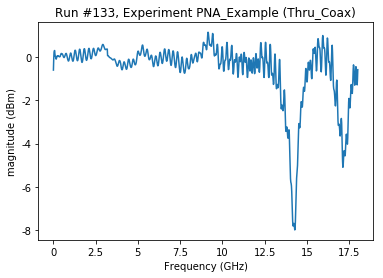

In [21]:
# Set up a frequency sweep from 100 MHz to 1 GHz, with 1001 points, at a power of -40dBm
channel.power(power)
channel.start(fstart)
channel.stop(fstop)
channel.points(points)

# Enable 2 averages, and set IF BW to 1kHz
channel.if_bandwidth(1e3)
channel.averages_enabled(True)
channel.averages(2) # alternatively, we can give the number of averages when calling "run_sweep"

# Run a measurement
meas = Measurement()
meas.register_parameter(trace.magnitude)

with meas.run() as datasaver:
    trace.select()  # make sure the proper trace is selected
    channel.run_sweep(averages=2)  
    # Unlike with the previous driver, there is no "auto_sweep", 
    # so we *always* explicitely call 'run_sweep'
    
    mag = trace.magnitude()
    datasaver.add_result((trace.magnitude, mag))
    dataid = datasaver.run_id
plot_by_id(dataid)

## Multiple Traces

We can also read multiple traces off the PNA at once. For example if the PNA is set up such that:
 - Trace 1 is S11
 - Trace 2 is S21
 - Trace 3 is S12
 - Trace 4 is S22
 
we can read these off simultaneously as follows:

In [28]:
# Lets clear the instrument
reset_instrument()

In [29]:
channel = pna.channels.add()
window = pna.windows.add()
# Trace S11 is added automatically when we add a channel
channel.traces.add(trace_type="S21")
channel.traces.add(trace_type="S12")
channel.traces.add(trace_type="S22")

<N52xxTrace: pna_CHN1_CHN1_S22_1 of N52xxChannel: pna_CHN1>

Starting experimental run with id: 136


([<matplotlib.axes._subplots.AxesSubplot at 0x2a52729b160>,
 [None, None, None, None])

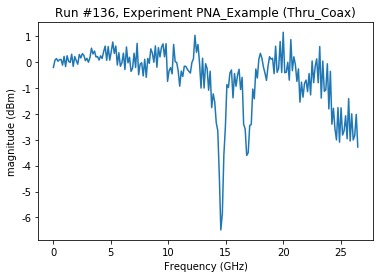

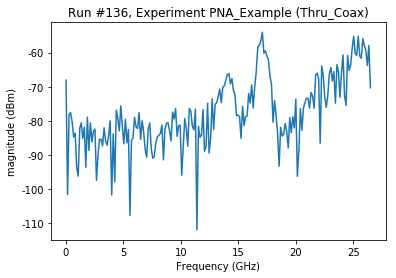

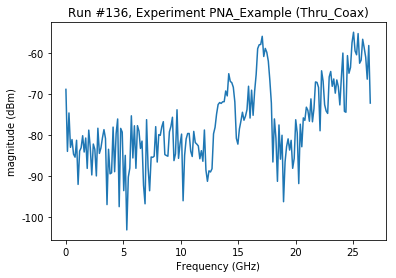

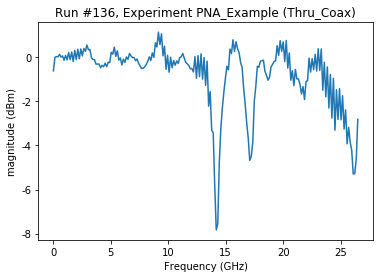

In [30]:
traces = channel.traces

# Run a measurement
meas = Measurement()

for trace in traces:
    meas.register_parameter(trace.magnitude)  
    window.add_trace(trace)

with meas.run() as datasaver:
    channel.run_sweep() 
    data = []
    for trace in traces:
        mag = trace.magnitude()
        data.append((trace.magnitude, mag))
    datasaver.add_result(*data)
    dataid = datasaver.run_id
plot_by_id(dataid)